In [1]:
from abtem import __version__

from abtem import *
from abtem.waves import FresnelPropagator, Waves
from ase.io import read

from abtem.visualize.interactive.artists import ImageArtist, AtomsArtist
from abtem.visualize.interactive.tools import SelectPositionTool1d

import numpy as np
import matplotlib.pyplot as plt
from abtem.visualize.interactive.canvas import Canvas

from ase import Atoms
from tqdm.auto import tqdm
import ipywidgets as widgets
import matplotlib.pyplot as plt
from traitlets import link, HasTraits, Float, Instance, Any, List, observe
from abtem.visualize.interactive.utils import Array, link

from ase.spacegroup import crystal
import time

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

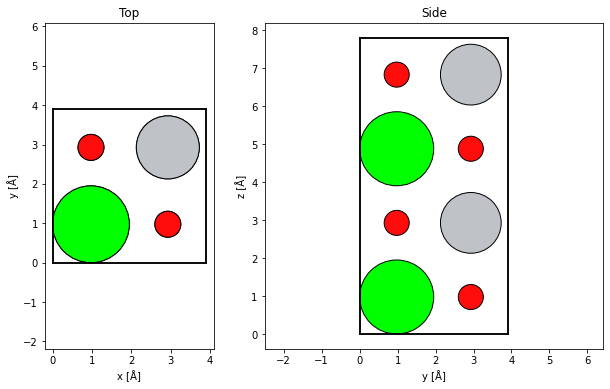

In [35]:
atom_pos = [(0.0, 0.0, 0.0), (0.5, 0.5, 0.5), (0.5, 0.5, 0.0)]
atoms = crystal(['Sr','Ti','O'], atom_pos, spacegroup=221, cellpar=3.905, size=(1, 1, 1))

atoms *= (1, 1, 2)
atoms.center()

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,6), gridspec_kw={'width_ratios': [1, 2]})
show_atoms(atoms, ax = ax1, title='Top')
show_atoms(atoms, plane='yz', ax = ax2, title='Side');

In [36]:
class SteppedMultislice(HasTraits):
    
    xy_image = Array()
    xz_image = Array()
    xy_extent = List()
    xz_extent = List()
    
    xz_limits_x = List()
    xz_limits_y = List()
    
    slice_thickness = Float(.5)
    pause_time = 1.0
    initial_wave = Any()
    potential = Any()
    atoms = Instance(Atoms)
    
    @observe('atoms', 'slice_thickness')
    def _observe_atoms(self, *args):
        self.potential = Potential(self.atoms, sampling=.02, 
                                   slice_thickness=self.slice_thickness, 
                                   projection='infinite', parametrization='kirkland')
    
    @observe('potential', 'initial_wave')
    def _observe_potential(self, *args):
        self.reset()
    
    def reset(self, *args):
        if self.initial_wave is None:
            return
            
        initial_wave = self.initial_wave[0]
        initial_wave_kwargs = self.initial_wave[1]
        initial_wave.match_grid(self.potential)
        
        initial_wave = np.squeeze(initial_wave.build(**initial_wave_kwargs).intensity().array)
        
        self.xy_image = initial_wave
        self.xz_image = initial_wave.sum(axis=1, keepdims=True)
        self.xy_extent = [(0,self.potential.extent[0]), (0,self.potential.extent[1])]
        self.xz_limits_x = (0,self.potential.extent[0])
        self.xz_limits_y = (- self.potential.slice_thickness ,self.potential.thickness)
        self.xz_extent = [(0, self.potential.extent[0]), (-self.potential.slice_thickness,0)]
        
    def run(self, *args):
        self.reset()
        
        potential = self.potential.build()
        propagator = FresnelPropagator()
        
        wave = self.initial_wave[0].build(**self.initial_wave[1])
        thickness = 0 #self.potential.slice_thickness
        
        for i, potential_slice in enumerate(potential):
            time.sleep(self.pause_time)
            potential_slice.transmit(wave)
            propagator.propagate(wave, potential_slice.thickness)
            xy_image = wave.intensity().array[0]
            
            self.xy_image = xy_image
            
            xz_image = self.xz_image.copy()
            xz_image = np.concatenate((xz_image, xy_image.sum(axis=1, keepdims=True)), axis=1)
            
            self.xz_image = xz_image
            
            thickness += potential_slice.thickness
            
            self.xz_extent = [(0,wave.extent[0]), (-self.potential.slice_thickness, thickness)]

In [42]:
stepped_multislice = SteppedMultislice(xy_image = np.zeros((1,1)), xz_image = np.zeros((1,1)))
stepped_multislice.atoms = atoms
stepped_multislice.initial_wave = (PlaneWave(energy=300e3), {})

canvas1 = Canvas(fig_margin={'top':10, 'bottom':50, 'left':50, 'right':0})
canvas2 = Canvas(width=200, lock_scale=False, fig_margin={'top':10, 'bottom':50, 'left':50, 'right':0})

canvas1.x_label = 'x [Å]'
canvas1.y_label = 'y [Å]'

canvas2.x_label = 'y [Å]'
canvas2.y_label = 'z [Å]'

xy_artist = ImageArtist()
xz_artist = ImageArtist(center_pixels=False)

canvas1.artists = {'image': xy_artist}
canvas2.artists = {'image': xz_artist}
canvas2.y_scale.reverse = True

link((stepped_multislice, 'xy_image'), (xy_artist, 'image'), check_broken=False)
link((stepped_multislice, 'xy_extent'), (xy_artist, 'extent'), check_broken=False)
link((stepped_multislice, 'xz_image'), (xz_artist, 'image'), check_broken=False)
link((stepped_multislice, 'xz_limits_x'), (canvas2, 'x_limits'), check_broken=False)
link((stepped_multislice, 'xz_limits_y'), (canvas2, 'y_limits'), check_broken=False)
link((stepped_multislice, 'xz_extent'), (xz_artist, 'extent'), check_broken=False)

initial_wave_dropdown = widgets.Dropdown(description='Initial wave', options=['Plane wave', 'Probe'])

def set_initial_wave(*args):
    if initial_wave_dropdown.value == 'Plane wave':
        stepped_multislice.initial_wave = (PlaneWave(energy=300e3), {})
    else:
        stepped_multislice.initial_wave = (Probe(energy=120e3, semiangle_cutoff=30), {'positions':(3,3)})

initial_wave_dropdown.observe(set_initial_wave, 'value')

slice_thickness_slider = widgets.FloatSlider(description='Slice thickness', min=0.1, max=3.01, value=1.)
link((slice_thickness_slider, 'value'), (stepped_multislice, 'slice_thickness'), check_broken=False)

run_button = widgets.Button(description='Run multislice')
run_button.on_click(stepped_multislice.run)

widgets.HBox([canvas1, canvas2, widgets.VBox([initial_wave_dropdown, slice_thickness_slider, run_button])])